## Tutorial for `score-analysis`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import score_analysis
from score_analysis import Scores

## Scores to ROC curves

We generate gaussian data with different means. Note that we create 10m data points for each the positive and the negative classes.

In [2]:
pos = np.random.normal(loc=5.0, scale=1.0, size=10_000_000)
neg = np.random.normal(loc=1.0, scale=1.0, size=10_000_000)

We look first at the score histogram.

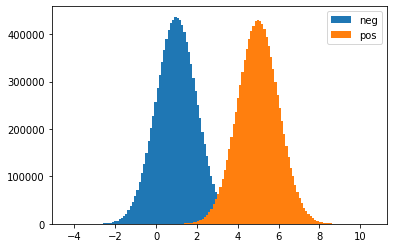

In [3]:
plt.figure()
plt.hist(neg, bins=100, label="neg")
plt.hist(pos, bins=100, label="pos")
plt.legend()
plt.show()

Create the scores object.

In [4]:
scores = Scores(pos, neg)

Next we plot the ROC curve, i.e., the FNR against FPR.

If the positive class means "accept" and the negative class means "reject", then
- FNR = FRR
- FPR = FAR

and so we plot FRR vs FAR.

We use FNR to set the threshold. In this case we have equal amounts of data in both classes, so we could also use FPR to set the threshold. In general we should use the class where we have more data available to set the threshold.

In [5]:
# We want to compute thresholds at approximately these FNR values
fnr_init = np.logspace(-6, 0, 100, endpoint=False)

# Thresholds underlying the ROC curve
threshold = scores.threshold_at_fnr(fnr_init)

# FNR and FPR values for these thresholds
fnr = scores.fnr(threshold)
fpr = scores.fpr(threshold)

Why are we calculating:
```
fnr_init -> threshold -> (fnr, fpr)
```
If we could have simply done this:
```
fnr -> threshold -> fpr
```

The reason is that the function `threshold_at_fnr()` is _approximate_. With a finite dataset, we obtain only finitely many FNR values, so we need to interpolate if we want to compute the threshold at any FNR value not covered by the dataset.

On the other hand, the functions `fnr()` and `tnr()` are _exact_. At a given threshold (after defining `score_class` and `equal_class`), there are well-defined FNR and TNR values, which we compute.

And so we use `threshold_at_fnr()` to compute a set of threshold that correspond approximately (as far as the dataset resolution allows) to the desired FNR values, given by `fnr_init`. And then we compute _exact_ FNR/TNR values at these thresholds.

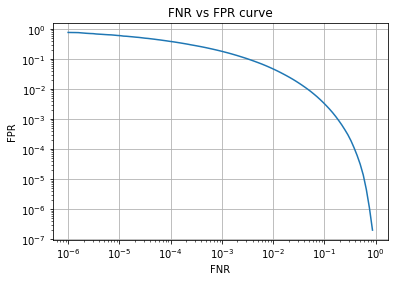

In [6]:
plt.figure()
plt.plot(fnr, fpr)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("FNR vs FPR curve")
plt.grid()
plt.show()

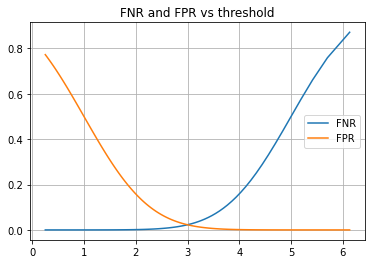

In [7]:
plt.figure()
plt.plot(threshold, fnr, label="FNR")
plt.plot(threshold, fpr, label="FPR")
plt.grid()
plt.legend()
plt.title("FNR and FPR vs threshold")
plt.show()

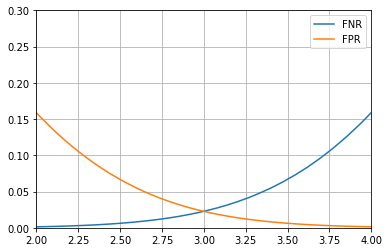

In [8]:
plt.figure()
plt.plot(threshold, fnr, label="FNR")
plt.plot(threshold, fpr, label="FPR")
plt.xlim((2, 4))
plt.ylim((0, 0.3))
plt.grid()
plt.legend()
plt.show()

Note that EER is achieved at the threshold 3.0, which is the midpoint between the two gaussian distributions.

In [9]:
eer_threshold, eer = scores.eer()
print(f"EER: {eer}")
print(f"EER threshold: {eer_threshold}")

EER: 0.02269806692493148
EER threshold: 2.998993659693154


## The ordering of scores

Assume that our scores are pointing the other way, i.e., a higher score indicates membership of the negative rather than the positive class.

In [10]:
pos = np.random.normal(loc=-3.0, scale=1.0, size=10_000_000)
neg = np.random.normal(loc=1.0, scale=1.0, size=10_000_000)

We specify this fact, when creating the scores object.

In [11]:
scores = Scores(pos, neg, score_class="neg")

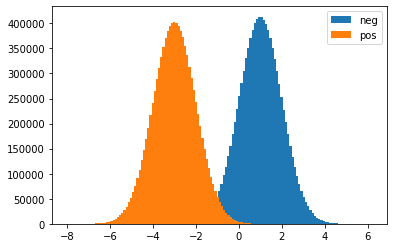

In [12]:
plt.figure()
plt.hist(neg, bins=100, label="neg")
plt.hist(pos, bins=100, label="pos")
plt.legend()
plt.show()

Now we draw the ROC curve again. Note that this code is completely unchanged from before.

In [13]:
# We want to compute thresholds at approximately these FNR values
fnr_init = np.logspace(-6, 0, 100, endpoint=False)

# Thresholds underlying the ROC curve
threshold = scores.threshold_at_fnr(fnr_init)

# FNR and FPR values for these thresholds
fnr = scores.fnr(threshold)
fpr = scores.fpr(threshold)

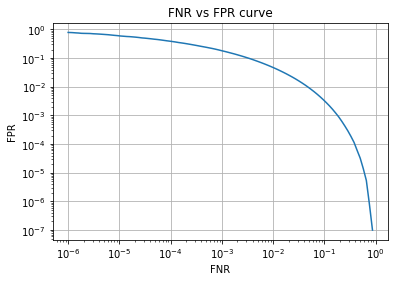

In [14]:
plt.figure()
plt.plot(fnr, fpr)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("FNR vs FPR curve")
plt.grid()
plt.show()

In [15]:
eer_threshold, eer = scores.eer()
print(f"EER: {eer}")
print(f"EER threshold: {eer_threshold}")

EER: 0.022798851685365662
EER threshold: -0.9999198390071742


## Edge case

What happens if we have repeated scores in the dataset? If in a large dataset a few scores are repeated, that will not change results much. But if we experience score saturation, e.g., a lot of positive samples are assigned score 1.0, that can impact results.

In general, score saturation should be avoided, e.g., by working with logits instead of probabilities. Usually the logits arising from a neural network are normally distributed, while the softmax-probabilities can saturate.

The `score-analysis` library can deal with repeated scores in a consistent manner, but the results might be somewhat counter-intuitive at first.

In [16]:
scores = Scores(
    pos=[0, 1, 1, 1], 
    neg=[0, 1, 1, 1],
    score_class="pos",
    equal_class="pos",
)

We plot FNR and FPR at various thresholds.

This graph is as expected. The graph is piecewise constant. At threshold 0.5 we mis-classify 
- 1/4 positives, so FNR = 0.25
- 3/4 negatives, so FPR = 0.75

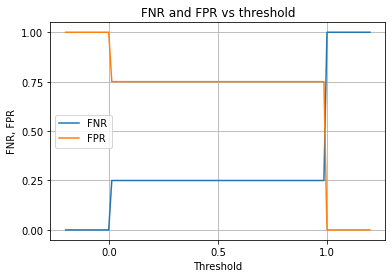

In [17]:
threshold = np.linspace(-0.2, 1.2, 100)
fnr = scores.fnr(threshold)
fpr = scores.fpr(threshold)

plt.figure()
plt.plot(threshold, fnr, label="FNR")
plt.plot(threshold, fpr, label="FPR")
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.grid()
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("FNR, FPR")
plt.title("FNR and FPR vs threshold")
plt.show()

Now we plot the treshold at given FNR and FPR values. Because of the interpolation, the resulting graph is piecewise linear.

In [18]:
x = np.linspace(0, 1, 100)
fnr_threshold = scores.threshold_at_fnr(x)
fpr_threshold = scores.threshold_at_fpr(x)

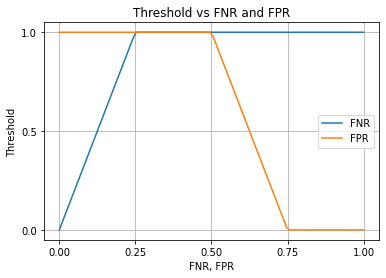

In [19]:
plt.figure()
plt.plot(x, fnr_threshold, label="FNR")
plt.plot(x, fpr_threshold, label="FPR")
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.5, 1])
plt.grid()
plt.legend()
plt.xlabel("FNR, FPR")
plt.ylabel("Threshold")
plt.title("Threshold vs FNR and FPR")
plt.show()

In [20]:
scores.eer()

(1.0, 0.375)

## Scores to confusion matrices

We can compute the confusion matrix at any threshold

In [21]:
threshold = np.linspace(-3, 3, 10)

In [22]:
cm = scores.cm(threshold)

In [23]:
type(cm)

score_analysis.cm.BinaryConfusionMatrix

In [24]:
cm.matrix.shape

(10, 2, 2)

In [25]:
cm.accuracy()

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

Available confusion matrix metrics

Basic parameters

1. TP (true positive)
2. TN (true negative)
3. FP (false positive)
4. FN (false negative)
5. P (condition positive)
6. N (condition negative)
7. TOP (test outcome positive)
8. TON (test outcome negative)
9. POP (population)

Class metrics

1. TPR (true positive rate) + confidence interval
2. TNR (true negative rate) + confidence interval
3. FPR (false positive rate) + confidence interval
4. FNR (false negative rate) + confidence interval
5. PPV (positive predictive value)
6. NPV (negative predictive value)
7. FDR (false discovery rate)
8. FOR (false omission rate)
9. Class accuracy
10. Class error rate

Overall metrics

1. Accuracy
2. Error rate

## General bootstrapping

In [26]:
def metric(scores: Scores) -> np.ndarray:
    # Simple metric calculating the mean of positive scores
    return np.mean(scores.pos)

scores = Scores(pos=[1, 2, 3], neg=[0, 2]) # Sample scores
ci = scores.bootstrap_ci(metric=metric, alpha=0.05, nb_samples=1000)
print(f"Metric 95%-CI: ({ci[0]:.4f}, {ci[1]:.4f})")

Metric 95%-CI: (1.0000, 3.0000)


In [30]:
# For metrics that are part of the Scores class we can pass their names
ci = scores.bootstrap_ci(metric="eer")
# Scores.eer() returns both threshold and EER value
print(f"Threshold 95%-CI: ({ci[0, 0]:.4f}, {ci[0, 1]:.4f})")
print(f"EER 95%-CI: ({ci[1, 0]:.3%}, {ci[1, 1]:.3%})")

Threshold 95%-CI: (0.5000, 2.0000)
EER 95%-CI: (0.000%, 100.000%)
